In [1]:
# Cell 1: Setup Kaggle and Download Data
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Data Science Bowl 2018 dataset
!kaggle competitions download -c data-science-bowl-2018

# Create directories and unzip the nested data
!mkdir -p dsb2018
!unzip -q data-science-bowl-2018.zip -d dsb2018
!mkdir -p dsb2018/stage1_train
!unzip -q dsb2018/stage1_train.zip -d dsb2018/stage1_train

print("Data downloaded and extracted successfully!")

 97% 347M/358M [00:00<00:00, 746MB/s] 
100% 358M/358M [00:00<00:00, 738MB/s]
Data downloaded and extracted successfully!


In [2]:
# Cell 2: Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

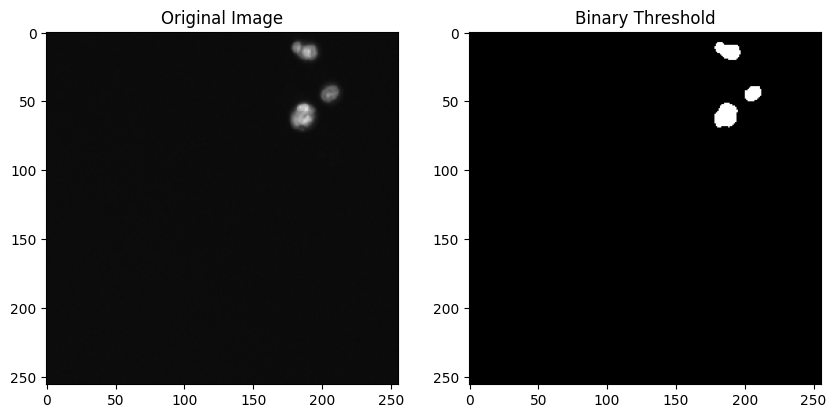

In [3]:
# Cell 3: Load Data and Preprocess
train_dir = 'dsb2018/stage1_train'
# Get a list of all individual image folder IDs
image_ids = next(os.walk(train_dir))[1]

# Let's pick the first image to work with
sample_id = image_ids[0]
image_path = os.path.join(train_dir, sample_id, 'images', f"{sample_id}.png")

# Read the image (cv2.watershed requires a 3-channel RGB/BGR image as input)
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Convert to grayscale for thresholding
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# Check background color. If background is bright, invert the image
# so nuclei are bright and background is dark.
if np.mean(gray) > 127:
    gray = cv2.bitwise_not(gray)

# Apply Otsu's thresholding to binarize the image
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(img_rgb), plt.title("Original Image")
plt.subplot(1, 2, 2), plt.imshow(thresh, cmap='gray'), plt.title("Binary Threshold")
plt.show()

In [4]:
# Cell 4: "Without Markers" - Simple Connected Components / Contours
# Find contours on the basic thresholded image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a copy of the original image
img_no_markers = img_rgb.copy()
cv2.drawContours(img_no_markers, contours, -1, (255, 0, 0), 2)

print(f"Number of nuclei detected Without Markers: {len(contours)}")

Number of nuclei detected Without Markers: 3


In [5]:
# Cell 5: Marker-Controlled Watershed

# 1. Noise removal (optional but good practice)
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# 2. Find Sure Background area (dilate the objects)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# 3. Find Sure Foreground area using Distance Transform
# The distance transform assigns higher values to pixels furthest from the background
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

# Threshold the distance transform to get the absolute centers of the nuclei
ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# 4. Find the unknown region (borders between cells)
unknown = cv2.subtract(sure_bg, sure_fg)

# 5. Create Markers
# Connected components labels the sure foreground objects (1, 2, 3...)
ret, markers = cv2.connectedComponents(sure_fg)

# Add 1 to all labels so that sure background is not 0, but 1
markers = markers + 1

# Mark the unknown region with 0
markers[unknown == 255] = 0

# 6. Apply Watershed Algorithm
img_watershed = img_rgb.copy()
# Watershed modifies the markers array in-place, assigning -1 to boundaries
markers = cv2.watershed(img_watershed, markers)

# Draw the boundaries (marked as -1) in red
img_watershed[markers == -1] = [255, 0, 0]

# Calculate how many cells were found (subtract 1 for the background label)
num_cells_watershed = np.max(markers) - 1
print(f"Number of nuclei detected With Markers: {num_cells_watershed}")

Number of nuclei detected With Markers: 3


=== SEGMENTATION METRICS COMPARISON ===
Metric          | Without Markers   | With Markers (Watershed)
----------------------------------------------------------
Jaccard (IoU)   | 0.8276            | 0.8333              
Dice (F1)       | 0.9057            | 0.9091              


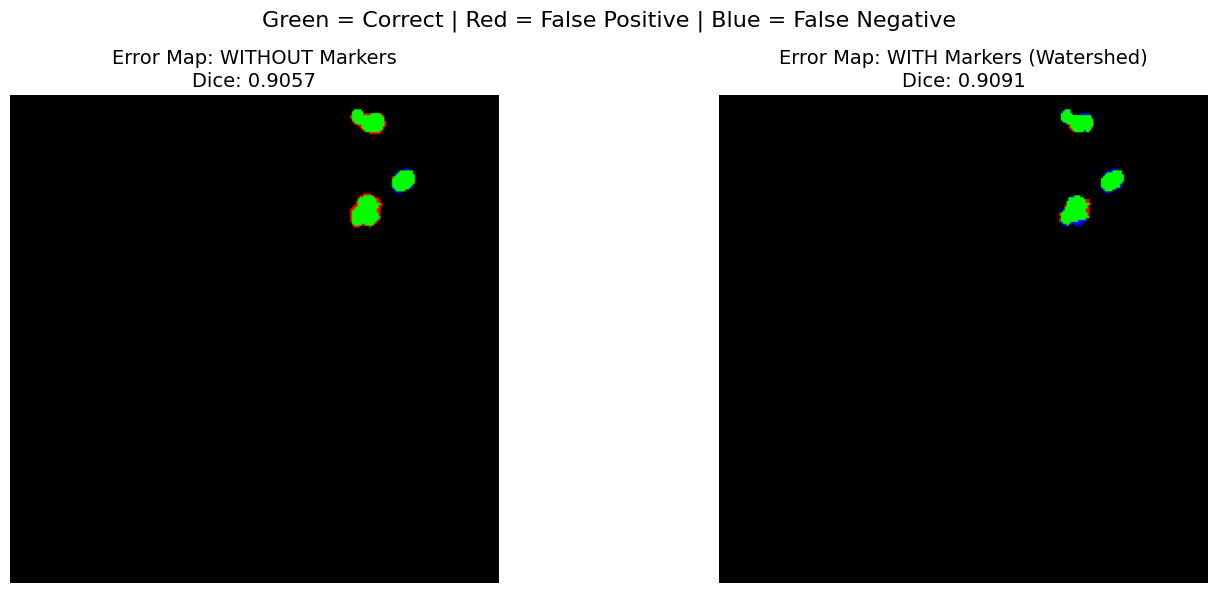

In [6]:
# Cell 7: Quantitative Evaluation (Dice & Jaccard)

# 1. Combine all individual ground truth masks into one single mask
mask_dir = os.path.join(train_dir, sample_id, 'masks')
gt_binary = np.zeros((img_bgr.shape[0], img_bgr.shape[1]), dtype=np.uint8)

for mask_file in os.listdir(mask_dir):
    mask_path = os.path.join(mask_dir, mask_file)
    individual_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt_binary = cv2.bitwise_or(gt_binary, individual_mask)

# Convert Ground Truth to boolean
y_true = gt_binary > 0

y_pred_naive = thresh > 0

intersection_naive = np.logical_and(y_true, y_pred_naive)
union_naive = np.logical_or(y_true, y_pred_naive)

jaccard_naive = np.sum(intersection_naive) / np.sum(union_naive)
dice_naive = 2 * np.sum(intersection_naive) / (np.sum(y_true) + np.sum(y_pred_naive))

# 3. Evaluate "WITH MARKERS" (Watershed)
watershed_binary = np.zeros_like(gt_binary)
watershed_binary[markers > 1] = 255  # Cells are labeled 2, 3, 4...
y_pred_watershed = watershed_binary > 0

intersection_water = np.logical_and(y_true, y_pred_watershed)
union_water = np.logical_or(y_true, y_pred_watershed)

jaccard_water = np.sum(intersection_water) / np.sum(union_water)
dice_water = 2 * np.sum(intersection_water) / (np.sum(y_true) + np.sum(y_pred_watershed))

print("=== SEGMENTATION METRICS COMPARISON ===")
print(f"{'Metric':<15} | {'Without Markers':<17} | {'With Markers (Watershed)':<20}")
print("-" * 58)
print(f"{'Jaccard (IoU)':<15} | {jaccard_naive:<17.4f} | {jaccard_water:<20.4f}")
print(f"{'Dice (F1)':<15} | {dice_naive:<17.4f} | {dice_water:<20.4f}")

def create_error_map(y_t, y_p):
    overlay = np.zeros_like(img_rgb)
    overlay[y_t & y_p] = [0, 255, 0]     # Perfect match (Green)
    overlay[~y_t & y_p] = [255, 0, 0]    # False Positive / Over-segmentation (Red)
    overlay[y_t & ~y_p] = [0, 0, 255]    # False Negative / Missed parts (Blue)
    return overlay

err_map_naive = create_error_map(y_true, y_pred_naive)
err_map_water = create_error_map(y_true, y_pred_watershed)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(err_map_naive)
plt.title(f"Error Map: WITHOUT Markers\nDice: {dice_naive:.4f}", fontsize=14)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(err_map_water)
plt.title(f"Error Map: WITH Markers (Watershed)\nDice: {dice_water:.4f}", fontsize=14)
plt.axis('off')

plt.suptitle("Green = Correct | Red = False Positive | Blue = False Negative", fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
# Cell 8: Evaluate Across the Entire Dataset
import pandas as pd
from tqdm import tqdm # For a nice progress bar

train_dir = 'dsb2018/stage1_train'
image_ids = next(os.walk(train_dir))[1]

results = []

print(f"Processing {len(image_ids)} images. This might take a minute or two...")

for sample_id in tqdm(image_ids):
    # 1. Paths
    image_path = os.path.join(train_dir, sample_id, 'images', f"{sample_id}.png")
    mask_dir = os.path.join(train_dir, sample_id, 'masks')

    # 2. Load Image & Preprocess
    img_bgr = cv2.imread(image_path)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Handle light/dark backgrounds
    if np.mean(gray) > 127:
        gray = cv2.bitwise_not(gray)

    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 3. Load and Merge Ground Truth Masks
    gt_binary = np.zeros((img_bgr.shape[0], img_bgr.shape[1]), dtype=np.uint8)
    for mask_file in os.listdir(mask_dir):
        mask_path = os.path.join(mask_dir, mask_file)
        individual_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        gt_binary = cv2.bitwise_or(gt_binary, individual_mask)
    y_true = gt_binary > 0

    # 4. WITHOUT MARKERS (Naive Approach)
    y_pred_naive = thresh > 0

    intersection_naive = np.sum(np.logical_and(y_true, y_pred_naive))
    union_naive = np.sum(np.logical_or(y_true, y_pred_naive))

    jaccard_naive = intersection_naive / (union_naive + 1e-8)
    dice_naive = 2 * intersection_naive / (np.sum(y_true) + np.sum(y_pred_naive) + 1e-8)

    # 5. WITH MARKERS (Marker-Controlled Watershed)
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)

    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    img_watershed = img_bgr.copy()
    markers = cv2.watershed(img_watershed, markers)

    watershed_binary = np.zeros_like(gt_binary)
    watershed_binary[markers > 1] = 255
    y_pred_water = watershed_binary > 0

    intersection_water = np.sum(np.logical_and(y_true, y_pred_water))
    union_water = np.sum(np.logical_or(y_true, y_pred_water))

    jaccard_water = intersection_water / (union_water + 1e-8)
    dice_water = 2 * intersection_water / (np.sum(y_true) + np.sum(y_pred_water) + 1e-8)

    # 6. Store Results
    results.append({
        "Method": "Without Markers",
        "Jaccard (IoU)": jaccard_naive,
        "Dice (F1)": dice_naive
    })
    results.append({
        "Method": "With Markers (Watershed)",
        "Jaccard (IoU)": jaccard_water,
        "Dice (F1)": dice_water
    })

# Display the Final Averaged Results
df = pd.DataFrame(results)
summary_df = df.groupby("Method").mean().round(4)

print("\n=== FINAL AVERAGE METRICS ACROSS ENTIRE DATASET ===")
display(summary_df)

Processing 670 images. This might take a minute or two...


100%|██████████| 670/670 [00:27<00:00, 24.30it/s]


=== FINAL AVERAGE METRICS ACROSS ENTIRE DATASET ===


,Jaccard (IoU),Dice (F1)
Method,,
With Markers (Watershed),0.7124,0.8124
Without Markers,0.7788,0.8571
